In [19]:
#get notebook runtime
from timeit import default_timer as timer
start = timer()

In [20]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
# Data Transformation
import pandas as pd
import geopandas as gpd
import numpy as np
import h3
import shapely

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx


# ML Processing
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Models
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso

# Neural Networks
from tensorflow import keras
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout

## Data Readin and Helper Functions

In [23]:
# Main Taxi Trip Data
df = pd.read_parquet("../data/df_cleaned_21_08_2021.parquet")
df = df.sample(10000)

df["PU_isWorkday"]=df["PU_isWorkday"].astype(int) #convert boolean to int for prediction

# a map that outlines the city of chicago
chicago = gpd.read_file("../data/chicago.geojson")

# Data containing Points of Interest
df_poi = pd.read_csv("../data/POI_per_H3.csv")

# Weather Data, pretransformed to be usable for prediction
weather_df = pd.read_parquet("../data/weather_transformed_22_08_2021.parquet")
weather_df["hour"] = weather_df["datetime"].dt.hour+1
weather_df["has_precipitation"] = weather_df["has_precipitation"].astype(int)
weather_df.drop(columns=["month","datetime"],inplace=True)

In [24]:
#https://www.datacourses.com/evaluation-of-regression-models-in-scikit-learn-846/
def eval_reg(y_test,y_pred,title=False):
    fig, ax = plt.subplots(1,2,figsize=(12,6))
    ax[0].scatter(y_pred, y_test, edgecolors=(0, 0, 1),alpha=0.1)
    ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')
    
    ax[1].hist(y_pred-y_test,bins=100)

    if title:
        fig.suptitle(title)
        
    plt.show()
    
    # model evaluation for testing set
    mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
    mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
    r2 = sklearn.metrics.r2_score(y_test, y_pred)
    max_error = sklearn.metrics.max_error(y_test, y_pred)#Calculating Max_Error

    print("The model performance for testing set")
    print("--------------------------------------")
    print('MAE is {}'.format(mae))
    print('MSE is {}'.format(mse))
    print('R2 score is {}'.format(r2))
    print('Max error is {}'.format(max_error))
    
    return [mae, r2]

### Characteristics

Let's recall the characteristics of our dataset:

In [25]:
df.shape

(10000, 43)

In [26]:
df.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,PU_HOUR,PU_isWorkday,DO_MONTH_NAME,DO_WEEKDAY_NAME,DO_WEEK,DO_DATE,DO_MONTH,DO_WEEKDAY,DO_HOUR,DO_isWorkday
22586188,608a87bfb6ebbd9aa9a71fe7c71753a3e0608bfd,2d49dd422b09d66e3e2da3120413ee76b8e28e19fd2e21...,2017-11-19 02:15:00,2017-11-19 02:15:00,291.0,1.00,NaN,NaN,NaN,NaN,...,3,0,November,Sunday,47,2017-11-19,11,6,3,False
3427684,0ecc7a859a321751afb09e78b4a83ed0585fee17,ba87ebcada16aad3f40ed6699a9e67512f64ef670e2777...,2017-02-22 20:30:00,2017-02-22 20:45:00,1020.0,14.60,NaN,NaN,NaN,NaN,...,21,1,February,Wednesday,8,2017-02-22,2,2,21,True
3929047,2685298e5add9e70018a5cd6d4040511de7e3f18,626cdd585f79a6edc840c5071e6ac0ba72539f065c3f50...,2017-03-01 16:15:00,2017-03-01 16:30:00,420.0,0.00,1.703184e+10,1.703184e+10,32.0,32.0,...,17,1,March,Wednesday,9,2017-03-01,3,2,17,True
1879681,028a19f81ae9d3a27f9c742894751680823b402f,41cea579c57a219c9909be94379401b4623c39a23b84e4...,2017-01-30 15:00:00,2017-01-30 15:15:00,773.0,2.33,NaN,NaN,NaN,NaN,...,16,1,January,Monday,5,2017-01-30,1,0,16,True
21307219,f0ead6723b54152594a3b793291a9c89a32d2f1d,4b92a02bf38d961c406e957edbe057dcafbd12d849d136...,2017-10-31 20:45:00,2017-10-31 21:15:00,1380.0,0.20,1.703108e+10,1.703106e+10,8.0,6.0,...,21,1,October,Tuesday,44,2017-10-31,10,1,21,True


In [27]:
df.isnull().sum()

Trip ID                          0
Taxi ID                          3
Trip Start Timestamp             0
Trip End Timestamp               0
Trip Seconds                     0
Trip Miles                       0
Pickup Census Tract           3059
Dropoff Census Tract          3086
Pickup Community Area          710
Dropoff Community Area         910
Fare                             0
Tips                             0
Tolls                         2631
Extras                           0
Trip Total                       0
Payment Type                     0
Company                          0
Pickup Centroid Latitude       710
Pickup Centroid Longitude      710
Dropoff Centroid Latitude      910
Dropoff Centroid Longitude     910
PU_H3                          710
DO_H3                          910
PU_DISTANCE_CITY               710
DO_DISTANCE_CITY               910
DURATION_IN_MINUTES              0
MPH                              0
PU_MONTH_NAME                    0
PU_WEEKDAY_NAME     

In [28]:
#df_pairplot = df[:100]

In [29]:
#sns.pairplot(df_pairplot, hue='PU_H3')

To get an overview of the data we this figure checks correlations between all variables. While some Variables show a strong correlations, others aren’t correlated at all. However, most correlations seem quite obvious: Timewise longer rides are also longer in distance, are associated with higher trip fares as well as tips. The negative correlation of the length of ride and Pick-up longitude hints at the fact that rides in the south of Chicago tend to be longer. This seems to be in line with the fact that the city center is in the north of the urban area of Chicago, so many customers might take the taxi ride towards the city center. 

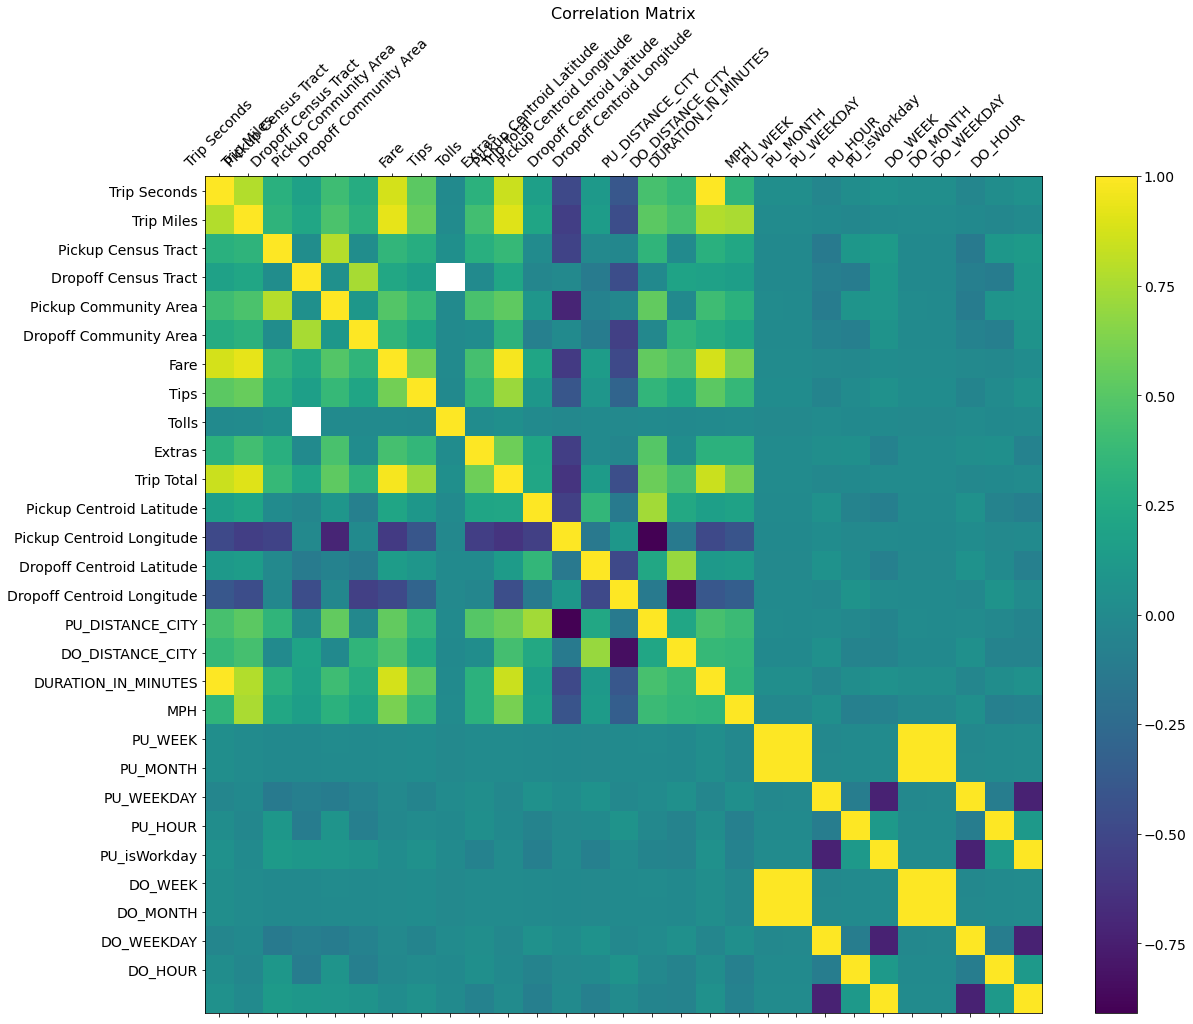

In [30]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Nun schauen wir uns die Verteilung unserer Zielvariablen taxi_demand (auf stündlicher basis) genauer an. Es ist zu erkennen, dass Samstags und Sonntags wesentlich häufiger früh am morgen das Taxi genutzt wird, als unter der Woche.

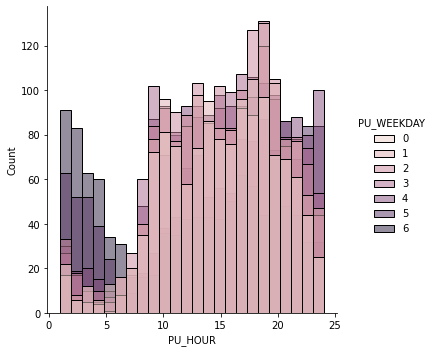

In [31]:
sns.displot(df,x='PU_HOUR', hue='PU_WEEKDAY', bins=24)


# 0. Data Preparation

The purpose of this part of the project is to build advanced models that can predict taxi demand in a certain area at a certain time frame. Consistent with the rest of the project, we use H3 coding for spatial segmentation. To get a feeling for the useful spatial resolutions that H3 offers, we start by plotting a map of chicago filled with different sized H3s to choose the relevant ones. We start with Level 9, as the data from our preprocessing (see Notebook Data Cleaning) is on Level 9, and then decrease the resolution.

The list below (taken from https://h3geo.org/docs/core-library/restable/) gives an impression of how big the hexagons in the respective resolution are.
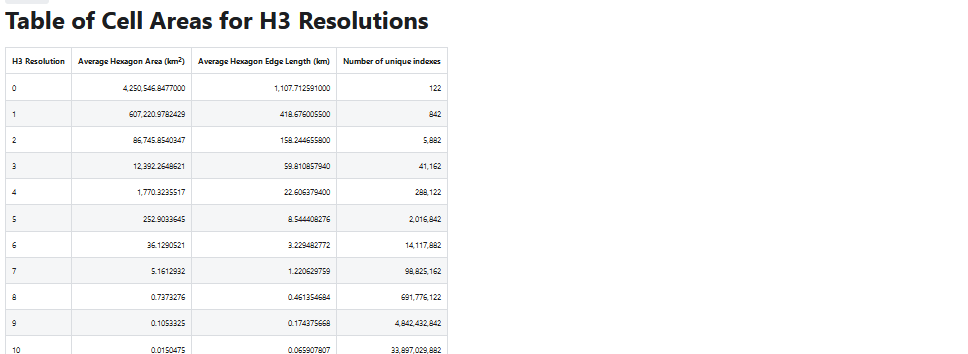

In [32]:
chicago_fence=chicago.geometry[0][1]

def get_chicago_gdf_h3(chicago_geojson,h3_res):
    # Create an empty dataframe to write data into
    h3_df = pd.DataFrame([],columns=['h3_id','geometry','h3_centroid'])


    # Iterate over every row of the geo dataframe
    for _,row in chicago.iterrows():  
        # Parse out info from columns of row
        district_multipolygon = row.geometry

        # Convert multi-polygon into list of polygons
        district_polygon = list(district_multipolygon)

        for polygon in district_polygon:
            # Convert Polygon to GeoJSON dictionary
            poly_geojson = gpd.GeoSeries([polygon]).__geo_interface__
            # Parse out geometry key from GeoJSON dictionary
            poly_geojson = poly_geojson['features'][0]['geometry'] 
            # Fill the dictionary with H3_hexagons
            h3_hexes = h3.polyfill_geojson(poly_geojson, h3_res) 
            for h3_hex in h3_hexes:
                h3_geo_boundary = shapely.geometry.Polygon(
                    h3.h3_to_geo_boundary(h3_hex,geo_json=True)
                )
                h3_centroid = h3.h3_to_geo(h3_hex)
                # Append results to dataframe
                h3_df.loc[len(h3_df)]=[
                    h3_hex,
                    h3_geo_boundary,
                    h3_centroid
                ]
    return h3_df

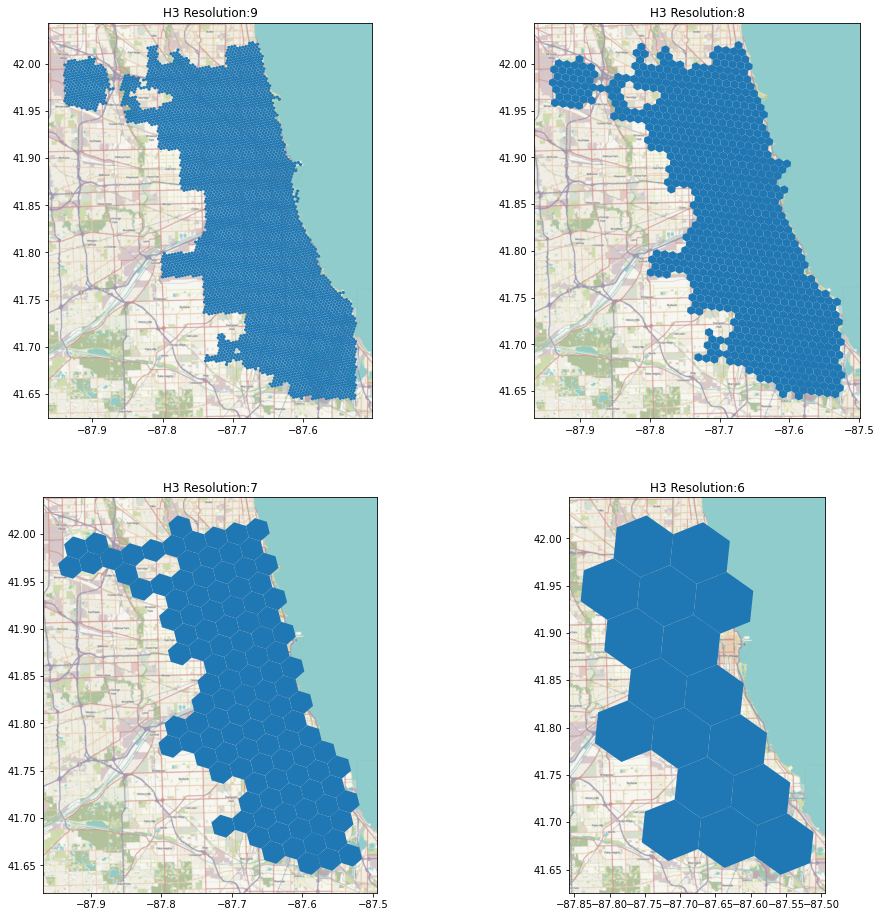

In [33]:
fig,axes=plt.subplots(2,2,figsize=(16,16))

h3_level = 9
for row in axes:
    for ax in row:
        h3_gdf = gpd.GeoDataFrame(get_chicago_gdf_h3(chicago, h3_level))
        h3_gdf.plot(ax=ax)
        ax.set_title("H3 Resolution:"+str(h3_level))
        ctx.add_basemap(ax=ax,zoom=12,crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
        chicago.plot(ax=ax,alpha=0) #scaling
        
        h3_level-=1

Predicting daily or hourly taxi demand for resolution 9 seems to be a little too detailed, while resolution 6 seems not detailed enough, so we focus on predicting on resolutions 7 and 8.

In terms of temporal resolutions, we find most interesting would be either daily, hourly, or 6-hourly.

### Preparing data for our chosen resolutions
To efficiently design our models for different resolutions and with different feature sets, we set up a reuseable function that builds a prediction dataframe for the desired temporal and spatial resolution. We add options to add dummy variables for 
* weather_description (~40 weather descriptions on hourly basis), 
* POI categories (~50 different categories of POI and their count in the specific H3), 
* H3 (Dummy Variable that can catch variance that is explained by only the predicted H3 polygon)

To obtain robust values for the predictors, we use the median.

In [34]:
def get_data(df,weather_df,df_poi,temp_resolution,spatial_resolution=False,dummy_poi_category=False,dummy_weather=False,dummy_h3=False):
    #Filter out all Data that doesn't have Pickup Location Data
    dff = df.copy()[df["PU_H3"].isnull()!=True]
    
    
    #---- Calculate new H3 based on specified resolution (if it is higher than resolution in dataset) -----#
    h3_base_resolution = h3.h3_get_resolution(dff["PU_H3"].iloc[0]) #get original resolution in data
    
    if h3_base_resolution<spatial_resolution:
        print("ERROR: Trying to select smaller resolution than available in dataset. Keeping data on resolution",h3_base_resolution)
        dff["PU_H3_pred"] = dff["PU_H3"]
        dff["DO_H3_pred"] = dff["DO_H3"]
        
    if h3_base_resolution == spatial_resolution:
        dff["PU_H3_pred"] = dff["PU_H3"]
        dff["DO_H3_pred"] = dff["DO_H3"]
        
    if spatial_resolution and spatial_resolution<h3_base_resolution:
        #calculate new H3s with centroids of old H3s
        dff["PU_H3_pred"] = dff.apply(lambda x: h3.geo_to_h3(x["Pickup Centroid Latitude"],x["Pickup Centroid Longitude"],spatial_resolution),axis=1)
        dff["DO_H3_pred"] = dff.apply(lambda x: h3.geo_to_h3(x["Dropoff Centroid Latitude"],x["Dropoff Centroid Longitude"],spatial_resolution),axis=1)
        
    
    dff_h3 = dff.groupby(["PU_H3_pred",
                               "PU_DATE",
                               "PU_HOUR"]).agg(H3_index=("PU_H3_pred","first"),
                                               DATE_index=("PU_DATE","first"),
                                               HOUR_index=("PU_HOUR","first"),
                                               count=("PU_H3","count"),
                                               MONTH=("PU_MONTH","first"),
                                               DISTANCE_CITY=("PU_DISTANCE_CITY","median"),
                                               WEEKDAY=("PU_WEEKDAY","first"),
                                               isWorkday=("PU_isWorkday","first"))
    
    dff_h3 = pd.merge(dff_h3,weather_df,left_on=["DATE_index","HOUR_index"],right_on=["date","hour"],how="left")
        
        
    #--------------------------- Slice Hours of Days into set Temporal Resolution ---------------------------#
    # This slices the day into equal parts. Input is the amount of slices per day.
    slicer = 24 / temp_resolution
    dff_h3["PU_HOUR_slice"] = np.ceil(dff_h3["HOUR_index"]/slicer).astype(int)
    
    
    dff_grouped = dff_h3.groupby(["H3_index",
                                   "DATE_index",
                                   "PU_HOUR_slice"]).agg(H3=("H3_index","first"),
                                                         DATE=("DATE_index","first"),
                                                         HOUR_slice=("PU_HOUR_slice","first"),
                                                         count=("count","sum"),#sums over all hours in slice
                                                         MONTH=("MONTH","first"),
                                                         DISTANCE_CITY=("DISTANCE_CITY","median"),
                                                         WEEKDAY=("WEEKDAY","first"),
                                                         isWorkday=("isWorkday","first"),
                                                         Temperature=("Temperature","median"),
                                                         Humidity=("Humidity","median"),
                                                         Wspeed=("Wind Speed","median"),
                                                         has_precipitation = ("has_precipitation","sum"),
                                                         precipitation_intensity_median=("precipitation_intensity","median"))




    #------------------------- Weather Description Dummies ----------------------#
    if dummy_weather:
        dff_grouped=dff_grouped.drop(columns=["has_precipitation","precipitation_intensity"])
        weather_df_dummies = weather_df.copy()[["date","hour","weather_description"]]
        weather_df_dummies = pd.concat([weather_df_dummies,
                                        pd.get_dummies(weather_df["weather_description"])],
                                       axis=1)
        weather_df_dummies["hour_slice"] = np.ceil(weather_df_dummies["hour"]/slicer).astype(int)
        weather_df_dummies = weather_df_dummies.drop(columns=["weather_description","hour"])

        weather_df_dummies = weather_df_dummies.groupby(["date","hour_slice"]).sum()
        dff_grouped=pd.merge(left=dff_grouped,
                             right=weather_df_dummies,
                             left_on=["DATE","HOUR_slice"],
                             right_index=True,
                             how="left")
        
        
        
    #---------------------------------------- POI ----------------------------------------#
    #get poi to right resolution
    
    dff_poi = df_poi.copy()
    dff_poi["area"]= dff_poi.apply(lambda x: h3.geo_to_h3(x["lng"],x["lat"],spatial_resolution),axis=1)
    if dummy_poi_category:
        dff_poi = dff_poi.drop(columns=["osm_id","feature","lat","lng","intersection"])
        dff_poi_index = dff_poi["area"]
        dff_poi = pd.get_dummies(dff_poi["key"])
        dff_poi.index = dff_poi_index
        dff_poi = dff_poi.groupby("area").sum().astype(int)
    else:
        dff_poi = dff_poi.groupby("area").agg(poi_count=("area","count"))
    
        
    dff_grouped=pd.merge(dff_grouped,dff_poi,left_on="H3",right_on="area",how="left")
    

    #----------------------------------- H3 Dummies --------------------------------------#

    
    if dummy_h3:
        h3_dummies = pd.get_dummies(dff_grouped["H3"])
        dff_grouped = pd.concat([dff_grouped,
                                 h3_dummies],axis=1)

    
    
    #----------------------------------- Output ------------------------------------#
    dff_grouped = dff_grouped.drop(columns=["H3","DATE"])
    dff_grouped=dff_grouped.replace(np.nan,0)
    return dff_grouped


## Benchmark: Simple Decision Tree and Linear Regressions
To get a benchmark, we set up simple Decision Tree and Linear Regressions as Benchmarks for our more complex, advanced Neural Networks and SVM Regressors. We use a reduced feature set without dummy variables in order to reduce model complexity, as these are just simple benchmark models.

In [35]:
df_pred_simple = get_data(df,weather_df,df_poi,6,8)

#Split off dependant and independant variable
y=df_pred_simple["count"]
X=df_pred_simple.drop(columns="count")

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Scaling
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

In [36]:
df_pred_simple.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8371 entries, 0 to 8370
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   HOUR_slice                      8371 non-null   int32  
 1   count                           8371 non-null   int64  
 2   MONTH                           8371 non-null   int64  
 3   DISTANCE_CITY                   8371 non-null   float64
 4   WEEKDAY                         8371 non-null   int64  
 5   isWorkday                       8371 non-null   int32  
 6   Temperature                     8371 non-null   float64
 7   Humidity                        8371 non-null   float64
 8   Wspeed                          8371 non-null   float64
 9   has_precipitation               8371 non-null   float64
 10  precipitation_intensity_median  8371 non-null   float64
 11  poi_count                       8371 non-null   float64
dtypes: float64(7), int32(2), int64(3)


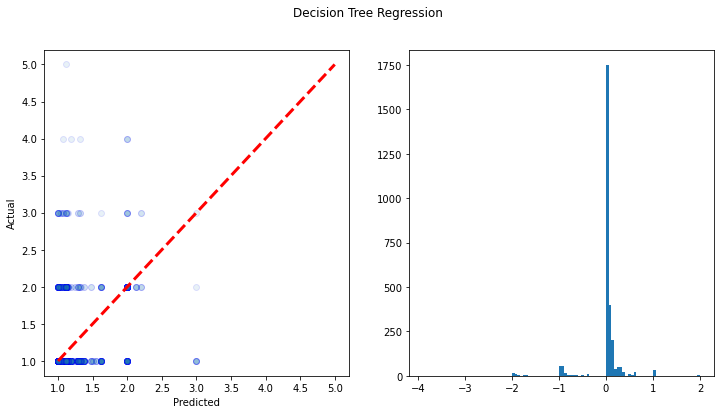

The model performance for testing set
--------------------------------------
MAE is 0.1404554859748574
MSE is 0.1277993308669951
R2 score is 0.08755088591922133
Max error is 3.8874074074074074


[0.1404554859748574, 0.08755088591922133]

In [37]:
tree=DecisionTreeRegressor(max_depth=10)
tree.fit(X_train_s,y_train)
y_pred=tree.predict(X_test_s)

eval_reg(y_test,y_pred,"Decision Tree Regression")

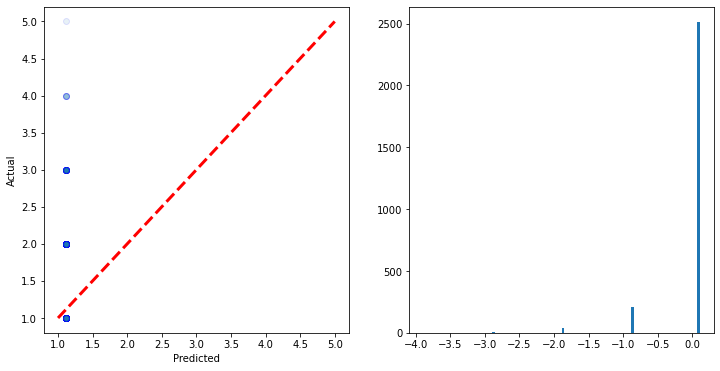

The model performance for testing set
--------------------------------------
MAE is 0.19925383209860478
MSE is 0.14006239010546445
R2 score is -3.700338406797954e-06
Max error is 3.889978601997147


[0.19925383209860478, -3.700338406797954e-06]

In [38]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_s,y_train)
y_pred=lasso.predict(X_test_s)

eval_reg(y_test,y_pred)

# 1. Neural Networks
Our Dataset for Neural Network Models contains all dummy variables, as Neural Networks are able to cope with a large input space and extract features on their own.

In [39]:
df_pred_ann = get_data(df,weather_df,df_poi,4,8,dummy_poi_category=True,dummy_weather=False,dummy_h3=True)

#Split off dependant and independant variable
y=df_pred_ann["count"]
X=df_pred_ann.drop(columns="count")

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Scaling
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

In [40]:
def build_reg_nn(layers,input_shape,activation="relu",dropout=False,optimizer="adam"):
    
    model = Sequential()
    model.add(keras.Input(shape=input_shape)) #Input Layer
    
    for layer in layers: # Hidden Layers
        model.add(Dense(layer, activation=activation)) #Add Hidden Layer with specified width and activation funciton
        if dropout: #if wanted, add dropout layer with given factor
            model.add(Dropout(dropout))
  

    model.add(Dense(1,activation="relu")) #Regression Output Layer - everything below 0 doesn't make sense here

    model.compile(loss='mse',
                  metrics=[metrics.RootMeanSquaredError()],
                  optimizer=optimizer)
    
    return model

### Basic Neural Network

Epoch 1/30
337/337 [==============================] - 1s 2ms/step - loss: 0.3411 - root_mean_squared_error: 0.5841
Epoch 2/30
337/337 [==============================] - 1s 2ms/step - loss: 0.2914 - root_mean_squared_error: 0.5398
Epoch 3/30
337/337 [==============================] - 1s 2ms/step - loss: 0.2860 - root_mean_squared_error: 0.5348
Epoch 4/30
337/337 [==============================] - 1s 3ms/step - loss: 0.2779 - root_mean_squared_error: 0.5272
Epoch 5/30
337/337 [==============================] - 1s 3ms/step - loss: 0.2704 - root_mean_squared_error: 0.5200
Epoch 6/30
337/337 [==============================] - 1s 3ms/step - loss: 0.2133 - root_mean_squared_error: 0.4618
Epoch 7/30
337/337 [==============================] - 1s 3ms/step - loss: 0.1929 - root_mean_squared_error: 0.4392
Epoch 8/30
337/337 [==============================] - 1s 3ms/step - loss: 0.1841 - root_mean_squared_error: 0.4290
Epoch 9/30
337/337 [==============================] - 1s 3ms/step - loss: 0.1712

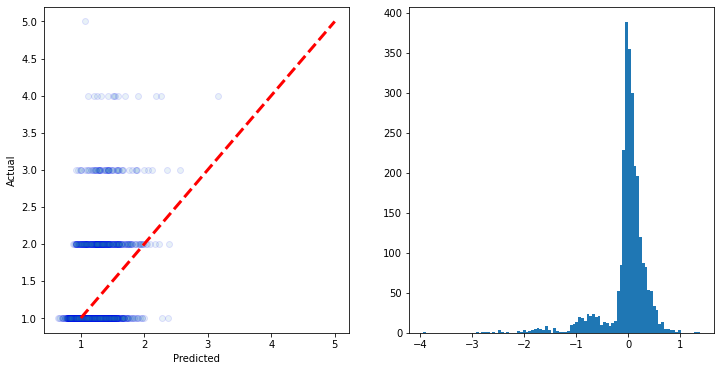

The model performance for testing set
--------------------------------------
MAE is 0.24203306607222683
MSE is 0.18249635162432923
R2 score is 0.16157102686860547
Max error is 3.9431670904159546


[0.24203306607222683, 0.16157102686860547]

In [41]:
#https://towardsdatascience.com/17-rules-of-thumb-for-building-a-neural-network-93356f9930af
model=build_reg_nn(layers=[64,32],input_shape=(X_train_s.shape[1],))
model.fit(X_train_s,y_train,batch_size=16,epochs=30)

y_pred=model.predict(X_test_s)
y_pred=y_pred.reshape(y_pred.shape[0],)

eval_reg(y_test,y_pred)

### Try increasing the Network Depth (adding 1 hidden layer)

Epoch 1/30
337/337 [==============================] - 1s 2ms/step - loss: 0.2757 - root_mean_squared_error: 0.5251
Epoch 2/30
337/337 [==============================] - 1s 2ms/step - loss: 0.1870 - root_mean_squared_error: 0.4325
Epoch 3/30
337/337 [==============================] - 1s 3ms/step - loss: 0.1746 - root_mean_squared_error: 0.4178
Epoch 4/30
337/337 [==============================] - 1s 3ms/step - loss: 0.1685 - root_mean_squared_error: 0.4105
Epoch 5/30
337/337 [==============================] - 1s 4ms/step - loss: 0.1651 - root_mean_squared_error: 0.4063
Epoch 6/30
337/337 [==============================] - 1s 4ms/step - loss: 0.1611 - root_mean_squared_error: 0.4014
Epoch 7/30
337/337 [==============================] - 1s 3ms/step - loss: 0.1610 - root_mean_squared_error: 0.4012
Epoch 8/30
337/337 [==============================] - 1s 3ms/step - loss: 0.1600 - root_mean_squared_error: 0.4000
Epoch 9/30
337/337 [==============================] - 1s 3ms/step - loss: 0.1579

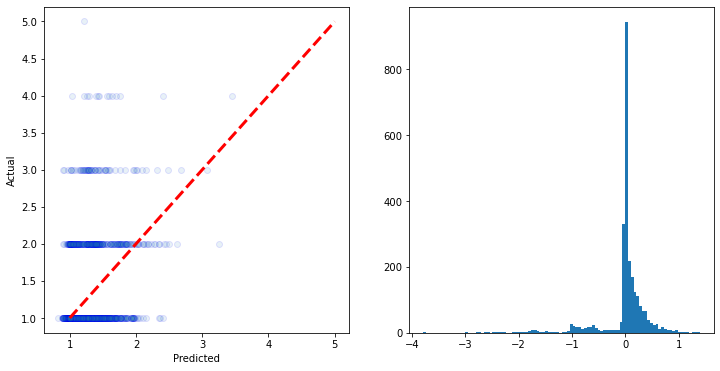

The model performance for testing set
--------------------------------------
MAE is 0.223337645088719
MSE is 0.1887926374270364
R2 score is 0.1326444845398449
Max error is 3.789005160331726


[0.223337645088719, 0.1326444845398449]

In [42]:
model=build_reg_nn(layers=[64,32,32],input_shape=(X_train_s.shape[1],))
model.fit(X_train_s,y_train,batch_size=16,epochs=30)

y_pred=model.predict(X_test_s)
y_pred=y_pred.reshape(y_pred.shape[0],)

eval_reg(y_test,y_pred)

### Try Increasing the Network Width

Epoch 1/30
337/337 [==============================] - 1s 2ms/step - loss: 0.5094 - root_mean_squared_error: 0.7137
Epoch 2/30
337/337 [==============================] - 1s 4ms/step - loss: 0.3961 - root_mean_squared_error: 0.6294
Epoch 3/30
337/337 [==============================] - 1s 4ms/step - loss: 0.3449 - root_mean_squared_error: 0.5873
Epoch 4/30
337/337 [==============================] - 1s 4ms/step - loss: 0.2006 - root_mean_squared_error: 0.4479
Epoch 5/30
337/337 [==============================] - 1s 4ms/step - loss: 0.1701 - root_mean_squared_error: 0.4124
Epoch 6/30
337/337 [==============================] - 1s 3ms/step - loss: 0.1665 - root_mean_squared_error: 0.4081
Epoch 7/30
337/337 [==============================] - 1s 4ms/step - loss: 0.1618 - root_mean_squared_error: 0.4022
Epoch 8/30
337/337 [==============================] - 1s 4ms/step - loss: 0.1584 - root_mean_squared_error: 0.3980
Epoch 9/30
337/337 [==============================] - 1s 4ms/step - loss: 0.1580

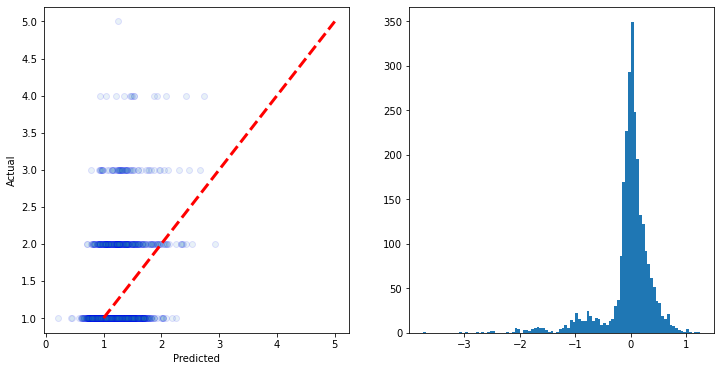

The model performance for testing set
--------------------------------------
MAE is 0.25929426856075094
MSE is 0.20014739726780484
R2 score is 0.08047818341265056
Max error is 3.7432613372802734


[0.25929426856075094, 0.08047818341265056]

In [43]:
model=build_reg_nn(layers=[128,64],input_shape=(X_train_s.shape[1],),activation="tanh")
model.fit(X_train_s,y_train,batch_size=16,epochs=30)

y_pred=model.predict(X_test_s)
y_pred=y_pred.reshape(y_pred.shape[0],)

eval_reg(y_test,y_pred)

### Use Tanh Activation instead of ReLu

Epoch 1/30
337/337 [==============================] - 1s 2ms/step - loss: 0.5943 - root_mean_squared_error: 0.7709
Epoch 2/30
337/337 [==============================] - 1s 4ms/step - loss: 0.3882 - root_mean_squared_error: 0.6231
Epoch 3/30
337/337 [==============================] - 1s 4ms/step - loss: 0.3470 - root_mean_squared_error: 0.5891
Epoch 4/30
337/337 [==============================] - 1s 4ms/step - loss: 0.2313 - root_mean_squared_error: 0.4809
Epoch 5/30
337/337 [==============================] - 1s 4ms/step - loss: 0.1733 - root_mean_squared_error: 0.4163
Epoch 6/30
337/337 [==============================] - 1s 4ms/step - loss: 0.1642 - root_mean_squared_error: 0.4052
Epoch 7/30
337/337 [==============================] - 1s 4ms/step - loss: 0.1613 - root_mean_squared_error: 0.4017
Epoch 8/30
337/337 [==============================] - 1s 4ms/step - loss: 0.1569 - root_mean_squared_error: 0.3961
Epoch 9/30
337/337 [==============================] - 1s 4ms/step - loss: 0.1581

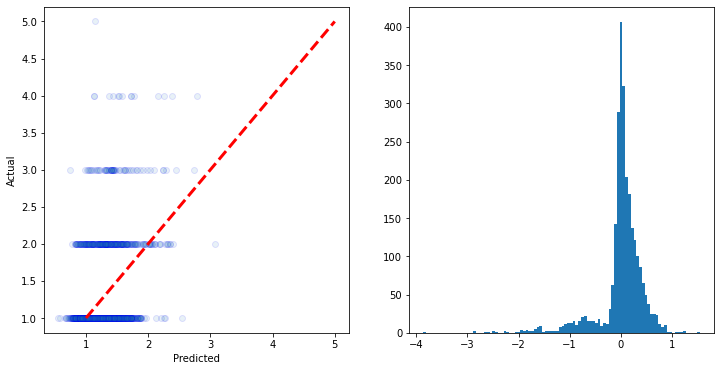

The model performance for testing set
--------------------------------------
MAE is 0.26120892243449995
MSE is 0.19287700491768114
R2 score is 0.113879988643939
Max error is 3.862859606742859


[0.26120892243449995, 0.113879988643939]

In [44]:
model=build_reg_nn(layers=[64,32],input_shape=(X_train_s.shape[1],),activation="tanh")
model.fit(X_train_s,y_train,batch_size=16,epochs=30)

y_pred=model.predict(X_test_s)
y_pred=y_pred.reshape(y_pred.shape[0],)

eval_reg(y_test,y_pred)

### Increase Epochs

Epoch 1/80
337/337 [==============================] - 0s 1ms/step - loss: 0.3828 - root_mean_squared_error: 0.6187
Epoch 2/80
337/337 [==============================] - 1s 2ms/step - loss: 0.2988 - root_mean_squared_error: 0.5466
Epoch 3/80
337/337 [==============================] - 1s 2ms/step - loss: 0.2909 - root_mean_squared_error: 0.5393
Epoch 4/80
337/337 [==============================] - 1s 2ms/step - loss: 0.2831 - root_mean_squared_error: 0.5320
Epoch 5/80
337/337 [==============================] - 1s 2ms/step - loss: 0.2378 - root_mean_squared_error: 0.4876
Epoch 6/80
337/337 [==============================] - 1s 2ms/step - loss: 0.2015 - root_mean_squared_error: 0.4489
Epoch 7/80
337/337 [==============================] - 1s 3ms/step - loss: 0.1847 - root_mean_squared_error: 0.4298
Epoch 8/80
337/337 [==============================] - 1s 3ms/step - loss: 0.1687 - root_mean_squared_error: 0.4107
Epoch 9/80
337/337 [==============================] - 1s 3ms/step - loss: 0.1620

337/337 [==============================] - 1s 2ms/step - loss: 0.1087 - root_mean_squared_error: 0.3297
Epoch 72/80
337/337 [==============================] - 1s 2ms/step - loss: 0.1093 - root_mean_squared_error: 0.3306
Epoch 73/80
337/337 [==============================] - 1s 2ms/step - loss: 0.1082 - root_mean_squared_error: 0.3290
Epoch 74/80
337/337 [==============================] - 1s 2ms/step - loss: 0.1078 - root_mean_squared_error: 0.3283
Epoch 75/80
337/337 [==============================] - 1s 2ms/step - loss: 0.1056 - root_mean_squared_error: 0.3249
Epoch 76/80
337/337 [==============================] - 1s 2ms/step - loss: 0.1080 - root_mean_squared_error: 0.3286
Epoch 77/80
337/337 [==============================] - 1s 2ms/step - loss: 0.1046 - root_mean_squared_error: 0.3234
Epoch 78/80
337/337 [==============================] - 1s 2ms/step - loss: 0.1044 - root_mean_squared_error: 0.3232
Epoch 79/80
337/337 [==============================] - 1s 2ms/step - loss: 0.1021 - 

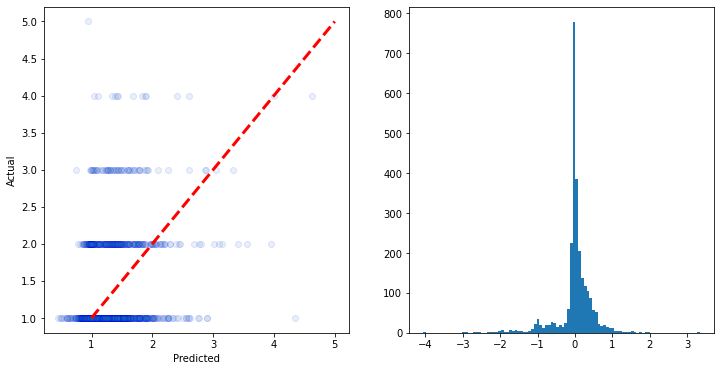

The model performance for testing set
--------------------------------------
MAE is 0.2616338513583821
MSE is 0.22003454804264458
R2 score is -0.010887826122606414
Max error is 4.057228446006775


[0.2616338513583821, -0.010887826122606414]

In [45]:
model=build_reg_nn(layers=[64,32],input_shape=(X_train_s.shape[1],),activation="relu")
model.fit(X_train_s,y_train,batch_size=16,epochs=80)

y_pred=model.predict(X_test_s)
y_pred=y_pred.reshape(y_pred.shape[0],)

eval_reg(y_test,y_pred)

When doing even more epochs, training loss seems to decrease further. However, there is not much change in test set performance. This indicates that the network starts to remember entries - which is considered as overfitting.

## Variation of Temporal and Spatial Resolution
We find that a basic neural network with two hidden layers with 64 and 32 nodes is capable of delivering very good results, while changing model characteristics doesn't seem to bring significant performance benefits. We try this network architecture to build a model for all of our resolutions and assess their respective performances.

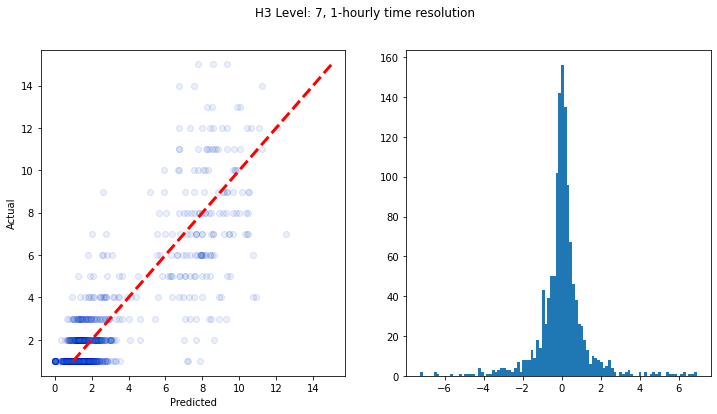

The model performance for testing set
--------------------------------------
MAE is 0.7635603510301847
MSE is 1.7336363103406311
R2 score is 0.7256970317845288
Max error is 7.264305114746094


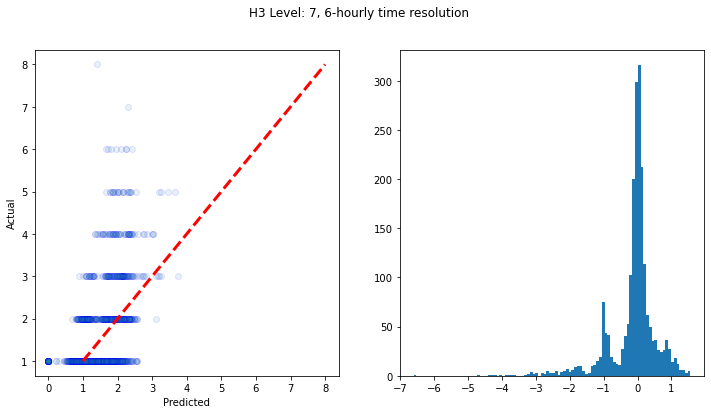

The model performance for testing set
--------------------------------------
MAE is 0.4358498778339285
MSE is 0.5498848420508196
R2 score is 0.2860774102099237
Max error is 6.606226682662964


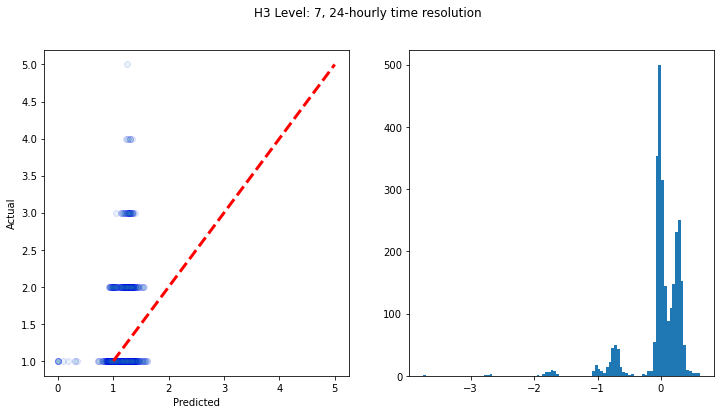

The model performance for testing set
--------------------------------------
MAE is 0.2202495678703368
MSE is 0.148417738253679
R2 score is 0.03549399630840544
Max error is 3.7493239641189575


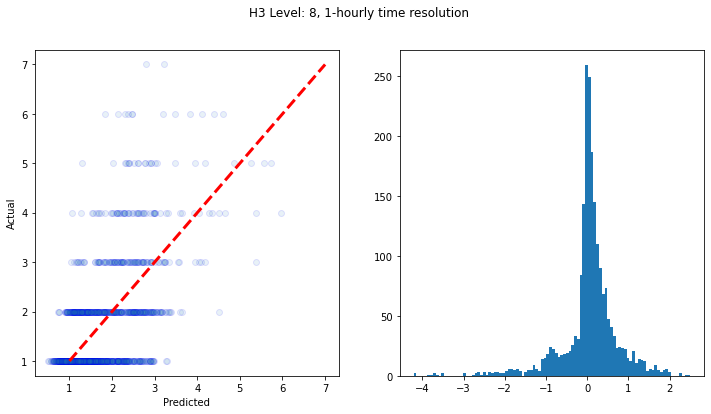

The model performance for testing set
--------------------------------------
MAE is 0.430635092960917
MSE is 0.4775797222568837
R2 score is 0.3815125277389848
Max error is 4.209344148635864


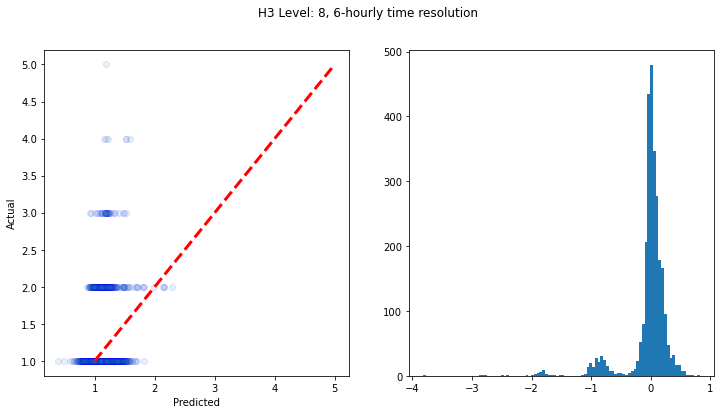

The model performance for testing set
--------------------------------------
MAE is 0.1853449443652498
MSE is 0.1339263486949511
R2 score is 0.0438058056347721
Max error is 3.816044807434082


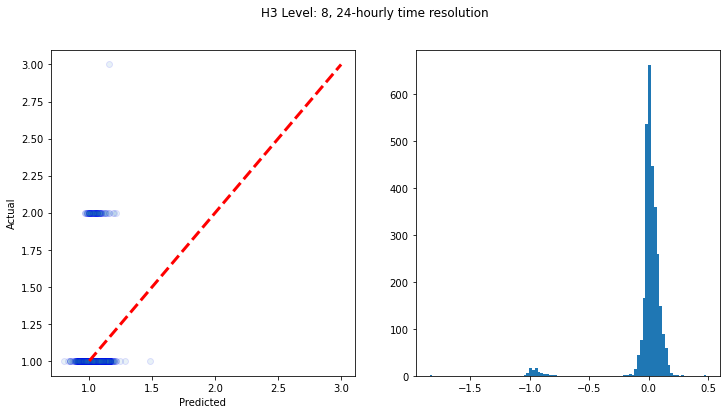

The model performance for testing set
--------------------------------------
MAE is 0.06737650182325515
MSE is 0.02811021487914001
R2 score is -0.04972677434838069
Max error is 1.8439269065856934


In [46]:
spatial_resolutions = [7,8]
temporal_resolutions = [1,6,24]

for spatial_resolution in spatial_resolutions:
    for temporal_resolution in temporal_resolutions:
        df_pred_loop = get_data(df,
                                weather_df,
                                df_poi,
                                temporal_resolution,
                                spatial_resolution,
                                dummy_poi_category=True,
                                dummy_weather=False,
                                dummy_h3=True)
        
                #Split off dependant and independant variable
        y=df_pred_loop["count"]
        X=df_pred_loop.drop(columns="count")

        #Train Test Split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

        #Scaling
        scaler = StandardScaler().fit(X_train)
        X_train_s = scaler.transform(X_train)
        X_test_s = scaler.transform(X_test)
        
        model=build_reg_nn(layers=[64,32],input_shape=(X_train_s.shape[1],))
        model.fit(X_train_s,y_train,batch_size=16,epochs=30,verbose=0) #suppresses progress bar

        y_pred=model.predict(X_test_s)
        y_pred=y_pred.reshape(y_pred.shape[0],)
        
        title="H3 Level: " + str(spatial_resolution) + ", "+str(temporal_resolution)+"-hourly time resolution"
        eval_reg(y_test,y_pred,title)

This architecture seems to work fine for almost all cases, however, for the daily resolution 

_____________________________________________________________

## 4. SVM

Now we proceed to model the relationship of the predictors with the demand using an SVR. We start with a simple model using no kernel. We then compare this against a model with kernel and improve our best model using a gridsearch over a predefined space of hyperparameters. We conclude this section by comparing the performance of the model over a variety of temporal and spacial resolutions.

For each model visualization and performance measures are beeing compared.

### 4.1.1 and 4.1.2. SVM Prediction and Evaluation

In [47]:
df_pred_svr = df_pred_ann

In [48]:
df_pred_svr.shape

(8042, 433)

As pointed out by the sklearn library, fit time complexity is more than quadratic with the number of samples using Sklearn's SVR, which makes it hard to scale to datasets with more than a couple of 10000 samples. Therefore, we sample a subset of our actual dataset to approximate the characteristics of our whole dataset

In [49]:
df_pred_svr = df_pred_svr.sample(n=5000) 

In [50]:
#Split off dependent and independent variable
y = df_pred_svr["count"]
X = df_pred_svr.drop(columns="count")

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Scaling
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

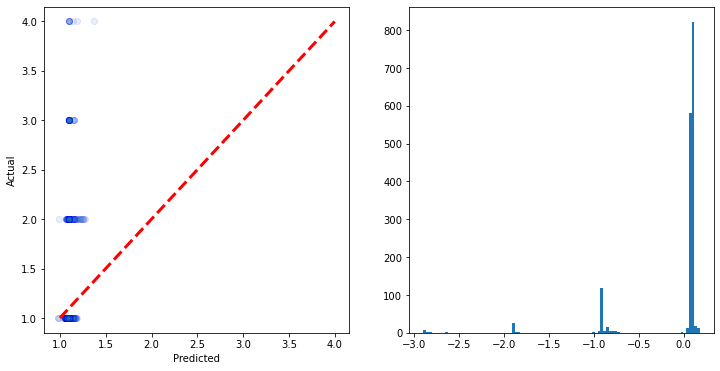

The model performance for testing set
--------------------------------------
MAE is 0.21871571166738077
MSE is 0.20075018293570368
R2 score is 0.012741470237405794
Max error is 2.9006997031024033


[0.21871571166738077, 0.012741470237405794]

In [51]:
#Start without a Kernel
model_svr = SVR()
model_svr.fit(X_train_s,y_train)
y_pred = model_svr.predict(X_test_s)

eval_reg(y_test,y_pred)

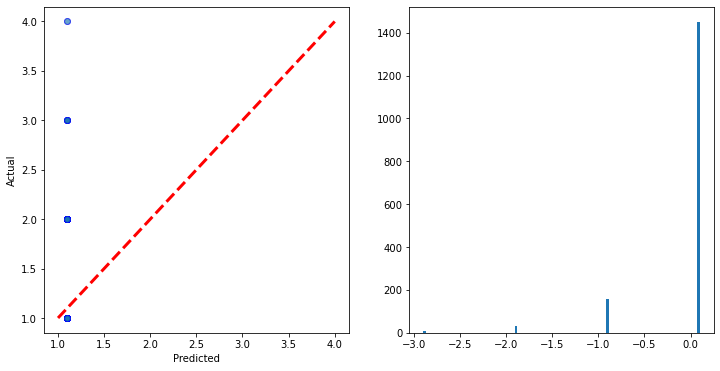

The model performance for testing set
--------------------------------------
MAE is 0.22830778489663334
MSE is 0.20611588276417975
R2 score is -0.013646216420420743
Max error is 2.900139771934785


[0.22830778489663334, -0.013646216420420743]

In [52]:
#Make more complex
model_svr2 = SVR(kernel='linear')
model_svr2.fit(X_train_s,y_train)
y_pred = model_svr2.predict(X_test_s)

eval_reg(y_test,y_pred)

As we can see, our model performs better with a linear kernel than with none (or RBF kernel, since that is used as default in Sklearn). This would suggest that our data is linearly separable based on the relatively large number of features.

#### Tune Hyperparameters

For tweaking the hyperparameters we are going to take a closer look at the Linear and Polynomial kernels. Other possibilities are 'sigmoid' and 'precomputed', which we will not include in the grid search due to memory restrictions. Further parameters are **C**: Regularization parameter, **Degree**: It is the degree of the polynomial kernel function ('poly') and **Gamma**: The kernel coefficient for 'rbf', 'poly', and 'sigmoid'.

In [53]:
#Tune Hyperparams
from sklearn.model_selection import GridSearchCV

param_grid = {'C':[0.1,1,10],'kernel':['linear']} #loop through predefined number of hyperparameters

grid = GridSearchCV(SVR(),param_grid)
grid.fit(X_train_s,y_train)

print(grid.best_params_)
print(grid.score(X_test_s,y_test))

{'C': 1, 'kernel': 'linear'}
-0.013646216420420743


Now we run our svr model with optimized hyperparameters based on the result of the gridsearch:

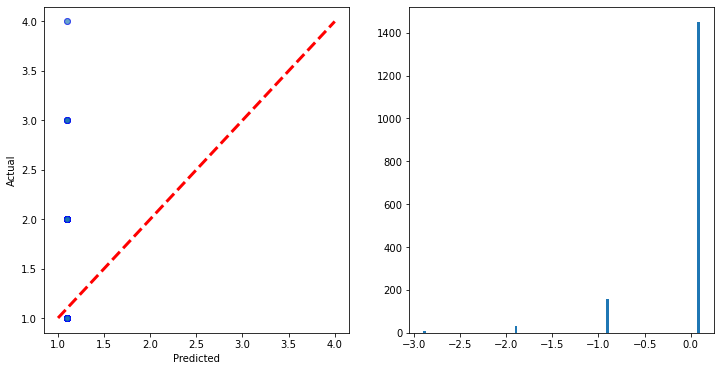

The model performance for testing set
--------------------------------------
MAE is 0.2282377489418978
MSE is 0.20610810833803156
R2 score is -0.01360798298811905
Max error is 2.900210371303117


[0.2282377489418978, -0.01360798298811905]

In [54]:
#Run Model with tuned hyperparams
model_svr3 = SVR(kernel='linear', C=10)
model_svr3.fit(X_train_s,y_train)
y_pred = model_svr3.predict(X_test_s)

eval_reg(y_test,y_pred)

### 4.1.3 Variation of Temporal and Spatial Resolution

In this section, we aim to explore the performance of our best model based on a variation of termporal and spatial resolutions.

In [55]:
#generate datasets - temporal dimension (slice per day, e.g., 4 beeing 4 slices, so 6 hour intervalls)
tempres_level = [1, 6, 24]
results=[]
for element in tempres_level:
    #shape new dataframe and repeat the usual process
    df_pred_svr = get_data(df,weather_df,df_poi,element,8,dummy_poi_category=True,dummy_weather=False,dummy_h3=True)
    if len(df_pred_svr) > 5000:
        df_pred_svr = df_pred_svr.sample(n=5000) 
    
    y=df_pred_svr["count"]
    X=df_pred_svr.drop(columns="count")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    scaler = StandardScaler().fit(X_train)
    X_train_s = scaler.transform(X_train)
    X_test_s = scaler.transform(X_test)

    
    #train and evaluate on new dataframe
    model = SVR(kernel='linear')
    model.fit(X_train_s,y_train)
    y_pred = model.predict(X_test_s)

    results.append((eval_reg(y_test,y_pred)) + [element])

end = timer()
print()
print("Total Notebook Runtime (s): ", end - start)

NameError: name 'results' is not defined

As you can observe, the prediction of demand is much more difficult for smaller time intervals, than for larger ones, such as from a whole day.